## Overview

0. Setting up autoencoder model
1. Experiment 1: existence of accidental polysemanticity
2. Experiment 2: confirming the random initialisations hypothesis
3. Experiment 3: quantifying the amount of polysemanticity
4. Experiment 4: inducing lossless polysemanticity with correlated features

For more information, see the [presentation](https://docs.google.com/presentation/d/1Ags2a7gR1yCUV6T3vZIw6Dt7KnZp45Lrdcw30I6EslU/edit?usp=sharing)!


## Defining the models

### Installing requisite packages

In [ ]:
!pip install einops

import math

import torch
from torch import nn
from torch.nn import functional as F

from typing import Optional

from dataclasses import dataclass, replace
import numpy as np
import einops

from tqdm.notebook import trange

import time
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.5 MB/s eta 0:00:00


### Class for Autoencoder

In [ ]:
@dataclass
class Config:
  n_features: int
  n_hidden: int
  n_instances: int
  inputs: str # basis or correlated vectors
  tied: bool # tied or untied weights
  distri: str # N(0,1/m) or N(0,2/n+m)
  bias: bool # with or without bias vector
  nonlinear: bool # with or without L1 and ReLU

class Model(nn.Module):
  def __init__(self,
               config,
               device='cuda'):
    super().__init__()
    self.config = config
    self.device = device
    if config.tied:
      self.W = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      if config.distri == "normal":
        nn.init.normal_(self.W, mean = 0, std = 1/math.sqrt(config.n_hidden))
      else:
        nn.init.xavier_normal_(self.W)
      self.W_initial = self.W.clone().detach()
    else:
      self.encoder = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      self.decoder = nn.Parameter(torch.empty((config.n_instances, config.n_features, config.n_hidden), device=device))
      if config.distri == "normal":
        nn.init.normal_(self.encoder, mean = 0, std = 1/math.sqrt(config.n_hidden))
        nn.init.normal_(self.decoder, mean = 0, std = 1/math.sqrt(config.n_hidden))
      else:
        nn.init.xavier_normal_(self.encoder)
        nn.init.xavier_normal_(self.decoder)
    if config.bias:
      self.bias = nn.Parameter(torch.zeros((config.n_instances, config.n_features), device=device))

  def forward(self, features):
    if self.config.tied:
      hidden = torch.einsum("...if,ifh->...ih", features, self.W)
      out = torch.einsum("...ih,ifh->...if", hidden, self.W)
    else:
      hidden = torch.einsum("...if,ifh->...ih", features, self.encoder)
      out = torch.einsum("...ih,ifh->...if", hidden, self.decoder)
    if self.config.bias:
      out = out + self.bias
    if self.config.nonlinear:
      out = F.relu(out)
    return out

  def generate_batch(self, n_batch):
    if self.config.inputs == "basis":
      identity_matrix = torch.eye(self.config.n_features, device = self.device)
      indices = torch.arange(self.config.n_features, device=self.device)
      batch = identity_matrix[indices]
      batch = batch.T
      batch = batch.unsqueeze(0).expand(self.config.n_instances, -1, -1)
      return batch
    else:
      batch = []
      for _ in range(n_batch):
        flip = torch.bernoulli(torch.tensor(0.5, device=self.device)).item()
        if flip == 1:
          top = torch.zeros(25,1, device=self.device)
          indices = torch.randperm(25, device=self.device)[:13]
          top[indices] = 1
          bottom = torch.zeros(25, 1, device=self.device)
        else:
          top = torch.zeros(25,1, device=self.device)
          bottom = torch.zeros(25, 1, device=self.device)
          indices = torch.randperm(25, device=self.device)[:13]
          bottom[indices] = 1
        tensor = torch.cat((top, bottom), dim = 0)
        tensor = torch.transpose(tensor, 0, 1)
        batch.append(tensor)
      batch = torch.stack(batch)
      batch.to(device=self.device)
      return batch

### Set up training details

In [ ]:
def linear_lr(step, steps):
  return (1 - (step / steps))

def constant_lr(*_):
  return 1.0

def cosine_decay_lr(step, steps):
  return np.cos(0.5 * np.pi * step / (steps - 1))

def optimize(model,
             render=False,
             n_batch=1024,
             steps=10_000,
             print_freq=100,
             lr=1e-3,
             lr_scale=constant_lr,
             l1_factor = 0.001):
  cfg = model.config

  opt = torch.optim.AdamW(list(model.parameters()), lr=lr)

  start = time.time()
  with trange(steps) as t:
    for step in t:
      step_lr = lr * lr_scale(step, steps)
      for group in opt.param_groups:
        group['lr'] = step_lr
      opt.zero_grad(set_to_none=True)
      batch = model.generate_batch(n_batch)
      out = model(batch)
      importance = torch.ones(())
      error = (importance*(batch.abs() - out)**2)
      loss = einops.reduce(error, 'b i f ->i', 'mean').sum()
      if cfg.nonlinear:
        if cfg.tied:
          l1_norm = torch.norm(model.W, p=1)
        else:
          l1_norm = torch.norm(model.encoder, p=1) + torch.norm(model.decoder, p=1)
        loss = loss + l1_factor * l1_norm
      loss.backward()
      opt.step()

      if step % print_freq == 0 or (step + 1 == steps):
        t.set_postfix(loss=loss.item(), lr=step_lr)

In [ ]:
if torch.cuda.is_available():
  DEVICE = 'cuda'
else:
  DEVICE = 'cpu'

## Existence of accidental polysemanticity

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

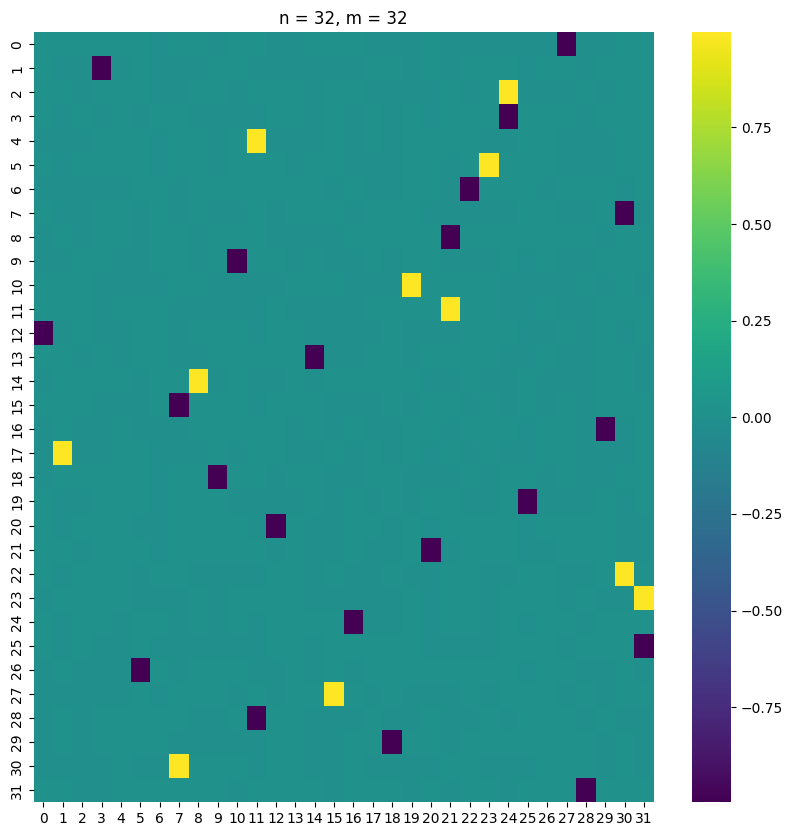

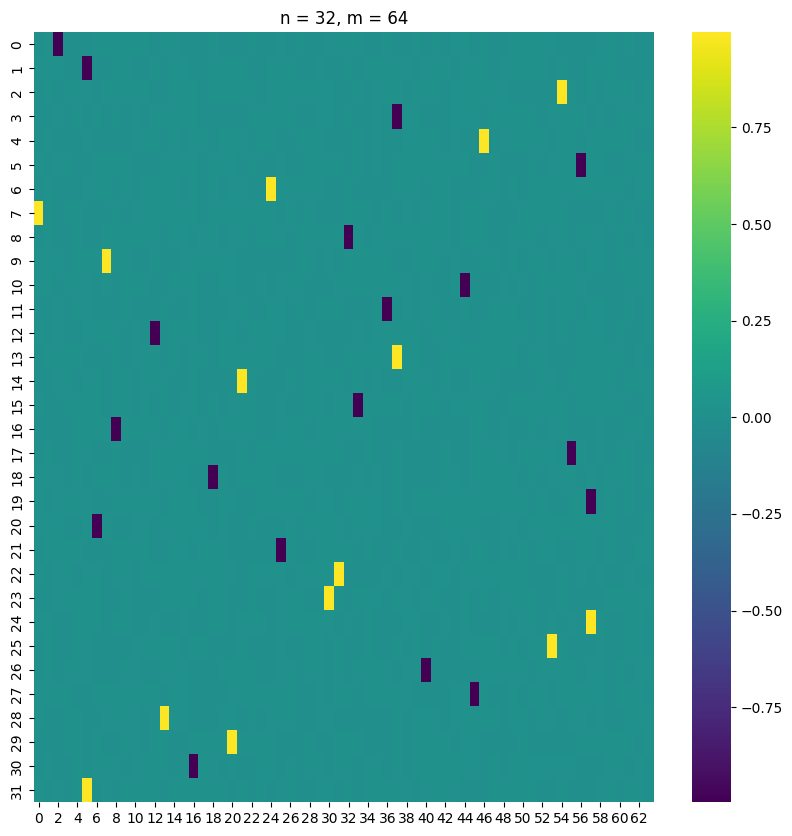

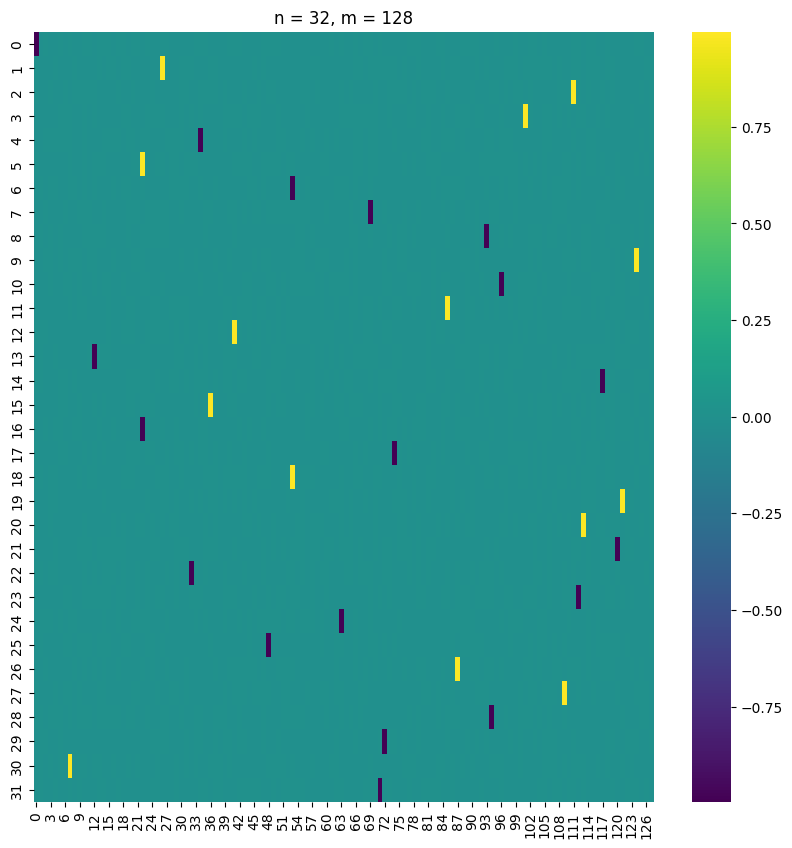

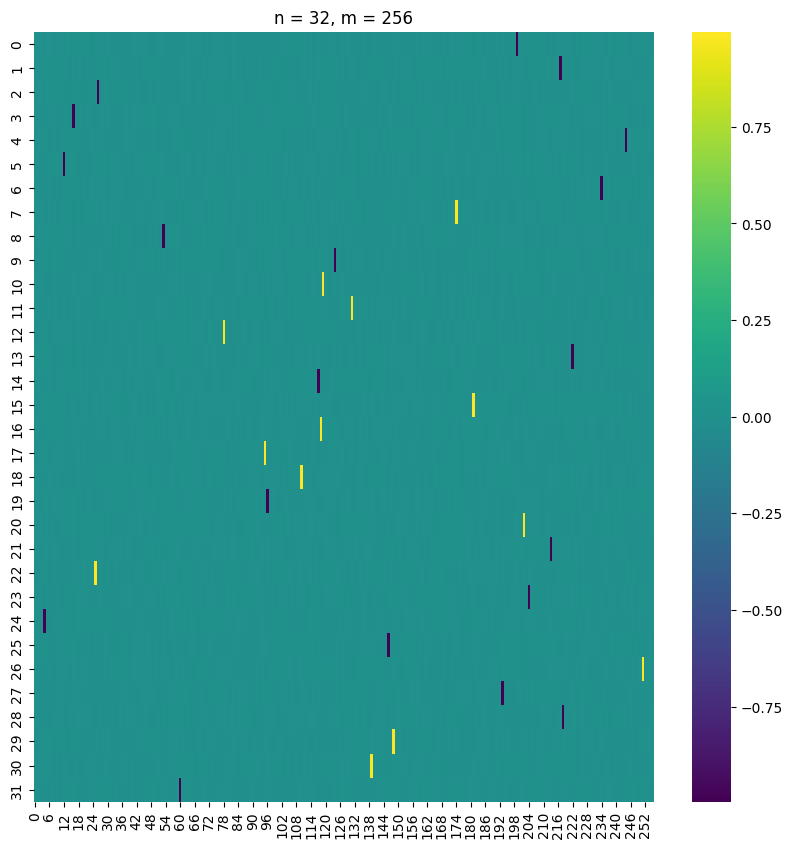

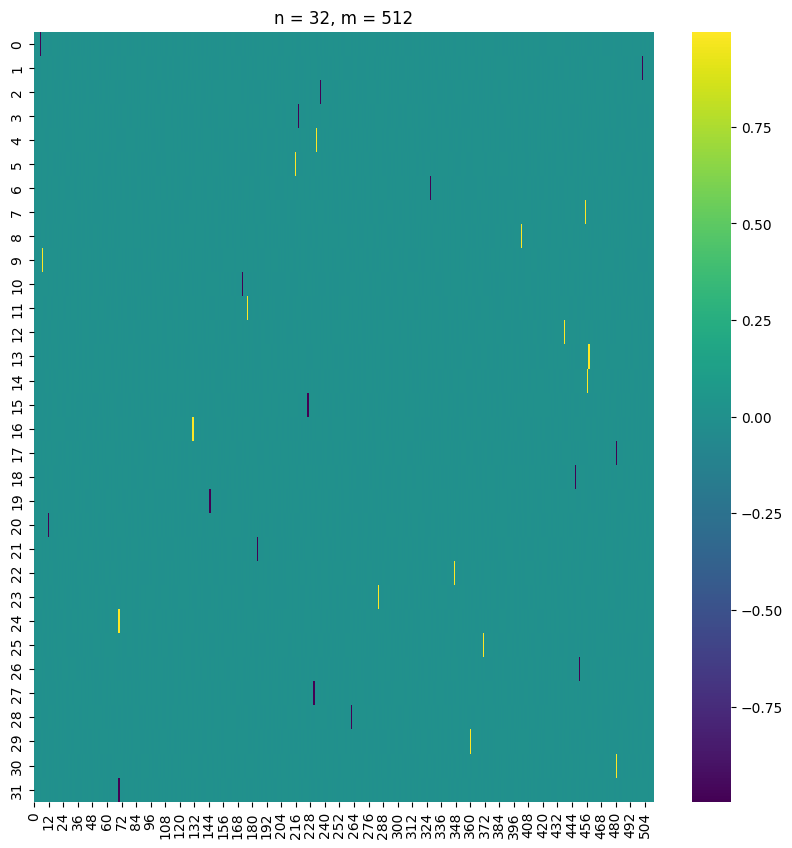

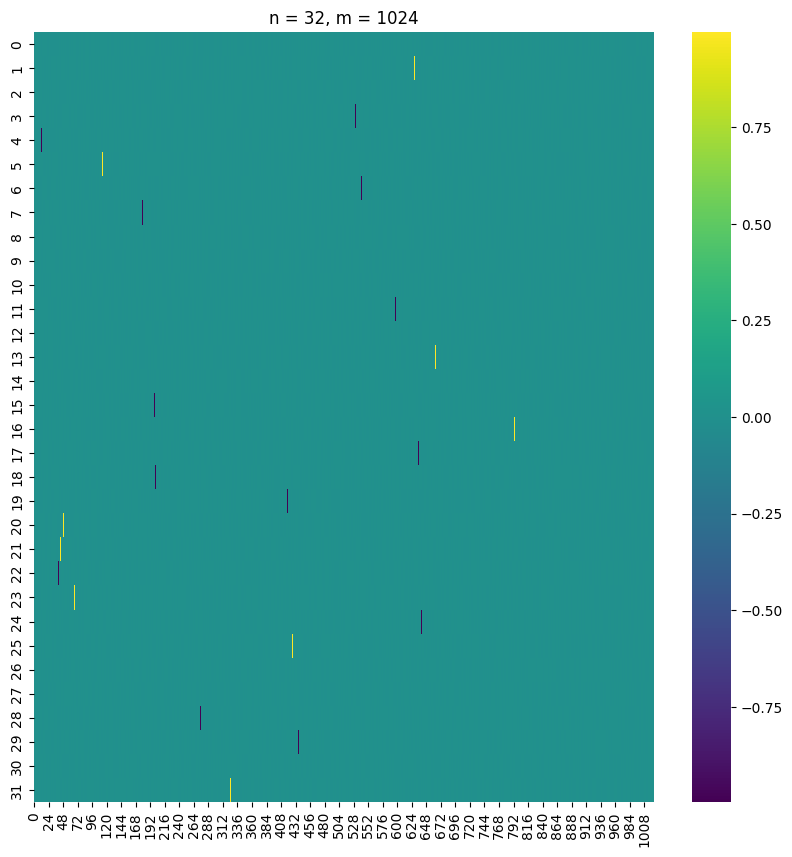

In [ ]:
hidden_32 = [32, 64, 128, 256, 512, 1024]

weights_32 = []
activations_32 = []
polysemantics_32 = []
plots_32 = []

for size in hidden_32:
  config = Config(
      n_features=32,
      n_hidden=size,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.001)

  weight_matrix = model.W.detach().cpu().numpy()
  weight_matrix = weight_matrix[0]
  weights_32.append(weight_matrix)
  absolute_matrix = np.abs(weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  count_total_activate = np.sum(activation_mask)
  activations_32.append(count_total_activate)

  # note we count polysemanticity by 0.8-1.2 here
  # this is because we expect to see 1 and -1
  count_neuron_activate = activation_mask.sum(axis=0)
  count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
  polysemantics_32.append(count_polysemantic)

  plt.figure(figsize=(10,10))
  sns.heatmap(weight_matrix, cmap="viridis")
  plt.title(f"n = 32, m = {size}")
  plots_32.append(plt.gcf())

In [ ]:
print(activations_32)
print(polysemantics_32)

[32, 32, 32, 32, 32, 32]
[6, 3, 2, 0, 2, 0]


## Confirming the random initialisations hypothesis

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

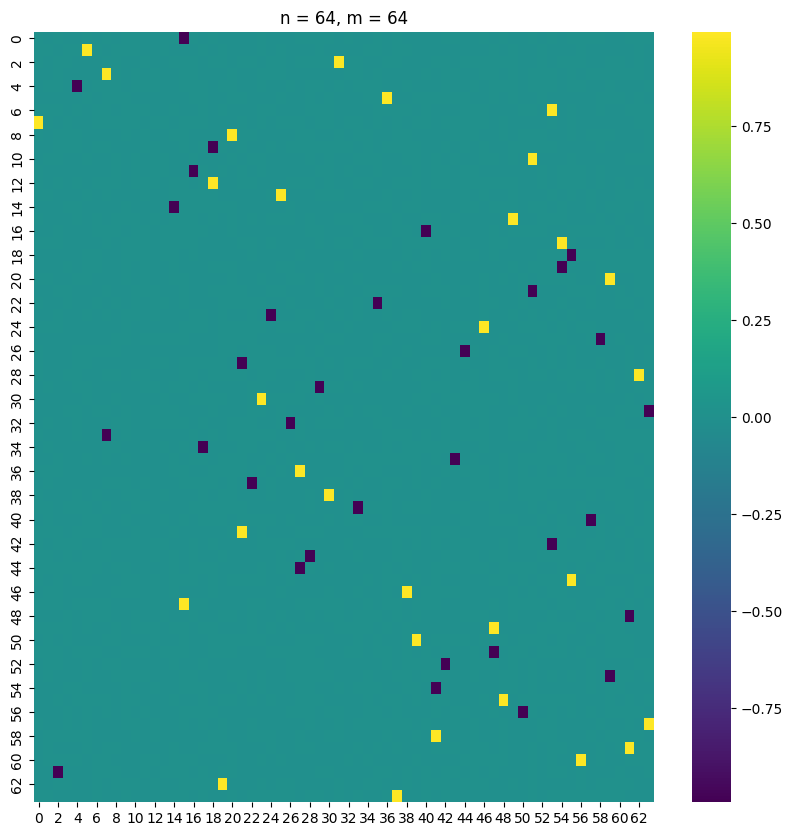

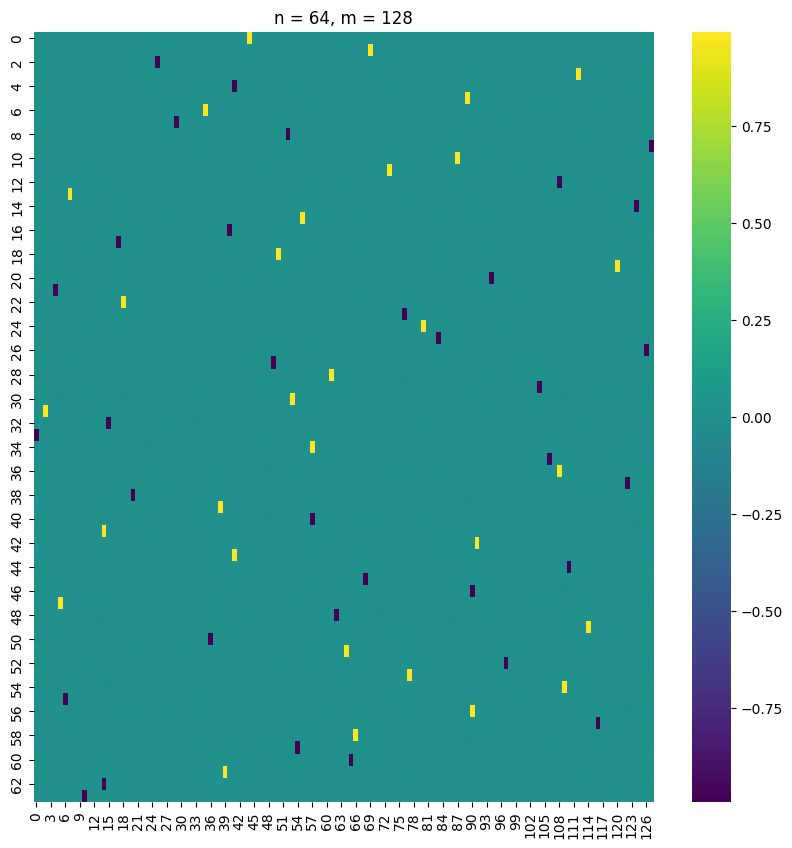

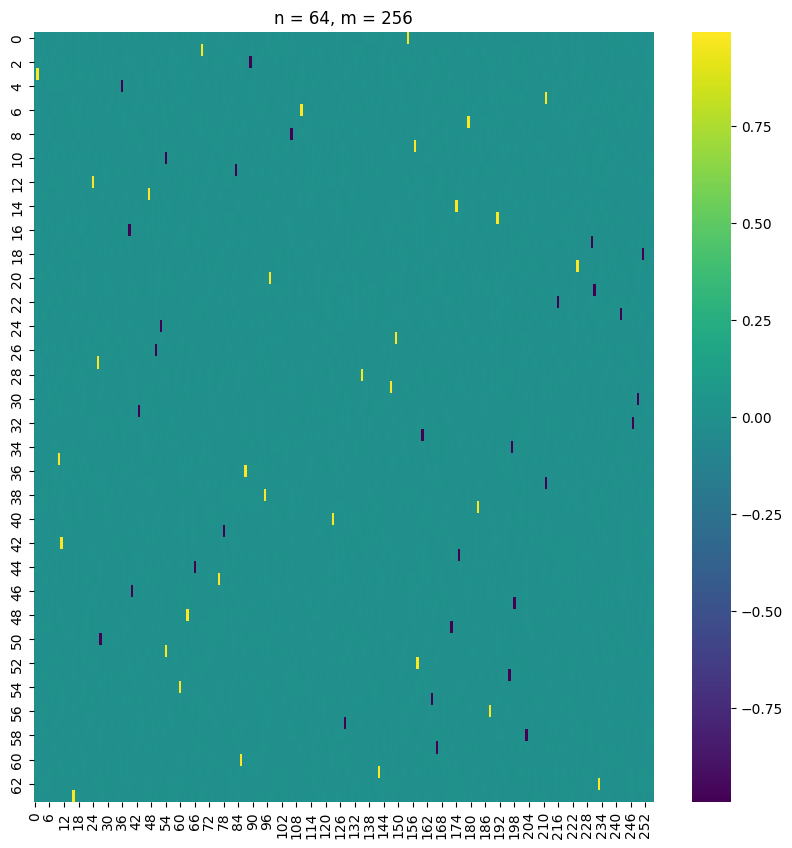

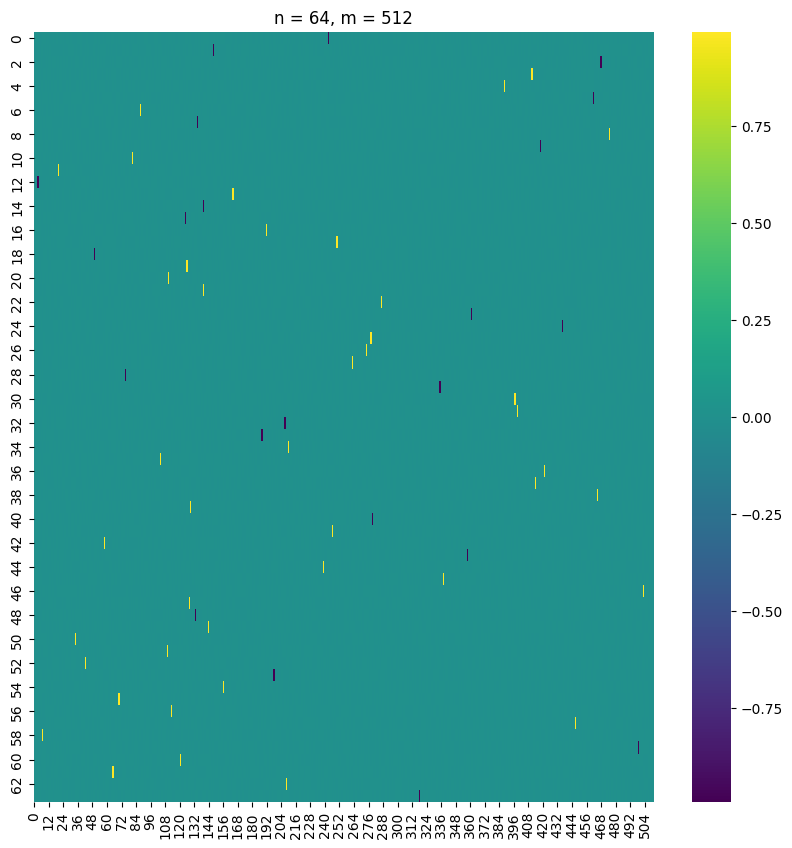

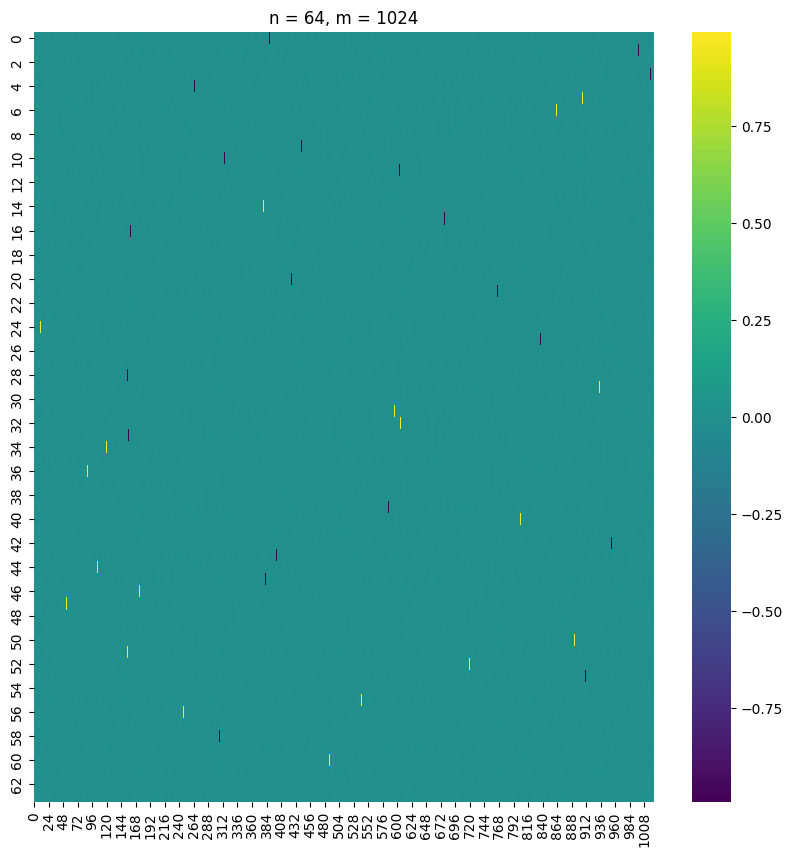

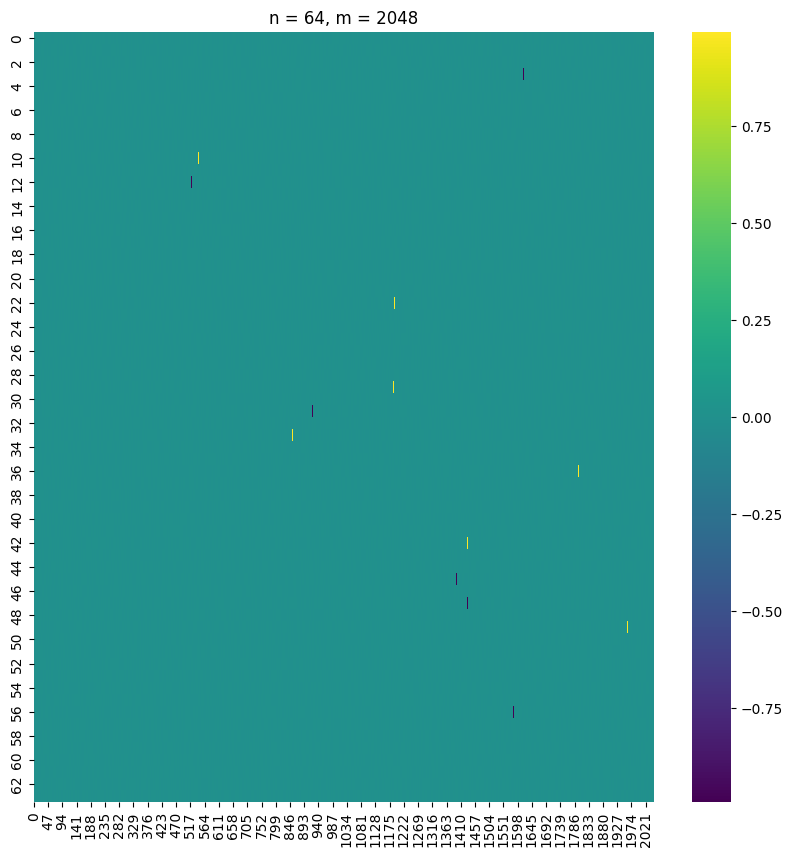

In [ ]:
hidden_64 = [64, 128, 256, 512, 1024, 2048]

start_weights_64 = []
weights_64 = []
activations_64 = []
polysemantics_64 = []
plots_64 = []

for size in hidden_64:
  config = Config(
      n_features=64,
      n_hidden=size,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.001)

  start_matrix = model.W_initial.detach().cpu().numpy()
  start_matrix = start_matrix[0]
  start_weights_64.append(start_matrix)

  weight_matrix = model.W.detach().cpu().numpy()
  weight_matrix = weight_matrix[0]
  weights_64.append(weight_matrix)
  absolute_matrix = np.abs(weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  count_total_activate = np.sum(activation_mask)
  activations_64.append(count_total_activate)

  # note we count polysemanticity by 0.8-1.2 here
  # this is because we expect to see 1 and -1
  count_neuron_activate = activation_mask.sum(axis=0)
  count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
  polysemantics_64.append(count_polysemantic)

  plt.figure(figsize=(10,10))
  sns.heatmap(weight_matrix, cmap="viridis")
  plt.title(f"n = 64, m = {size}")
  plots_64.append(plt.gcf())

In [ ]:
print(activations_64)
print(polysemantics_64)

[64, 64, 64, 64, 64, 64]
[14, 5, 2, 1, 1, 4]


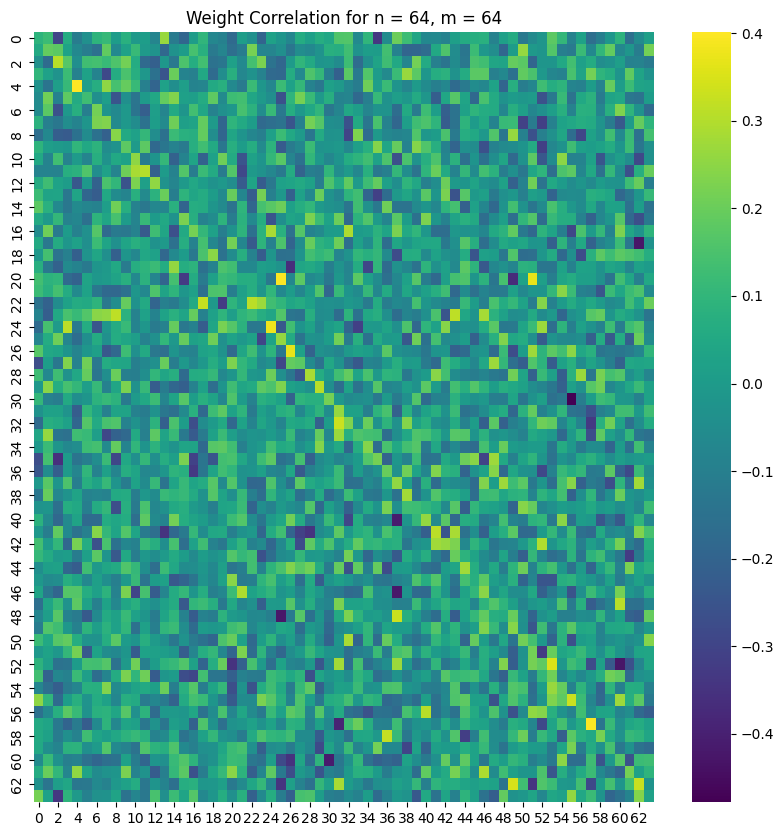

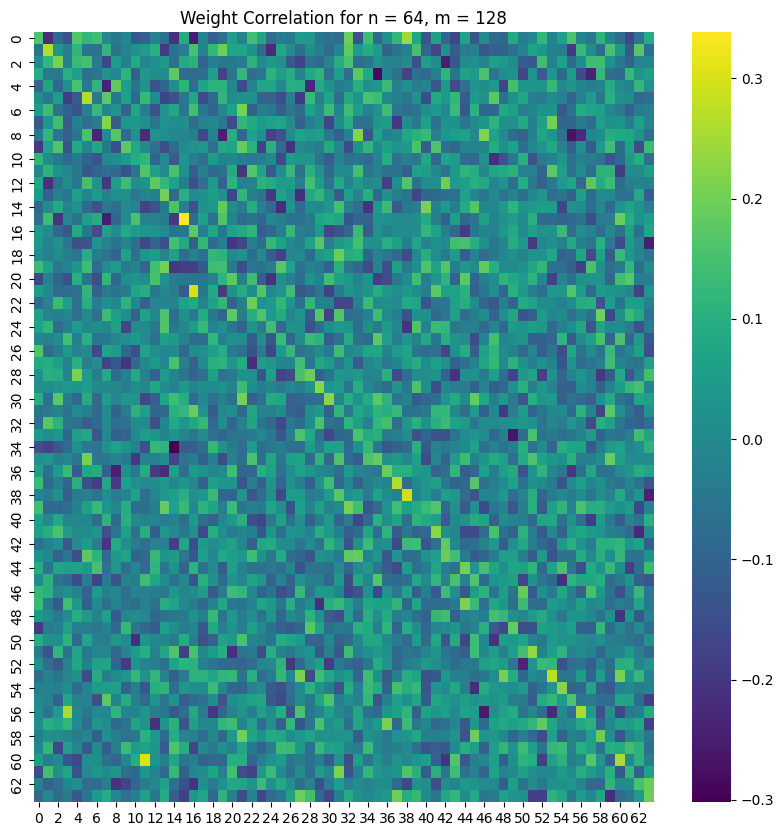

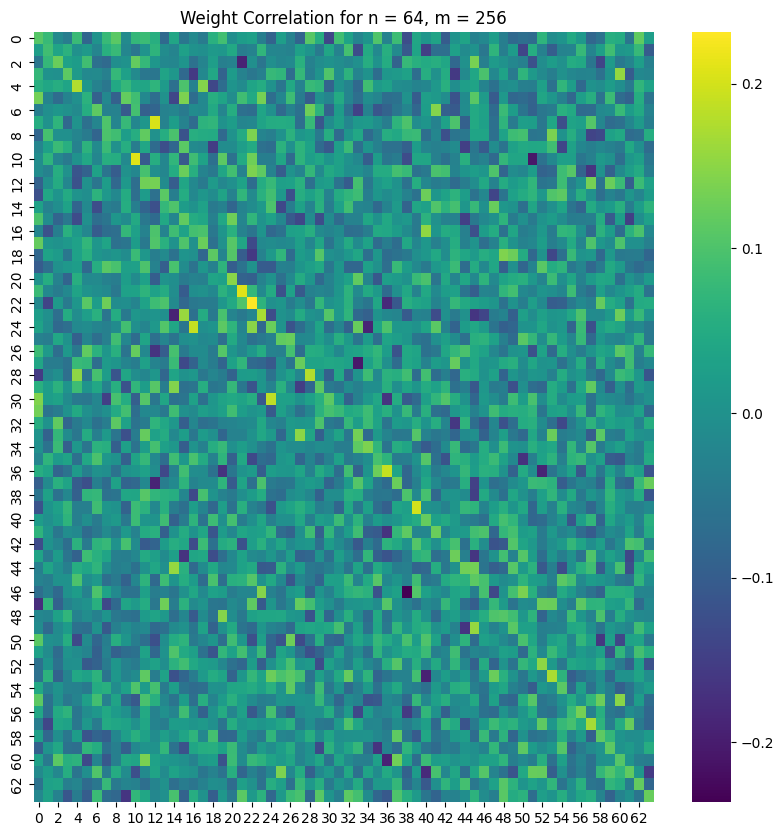

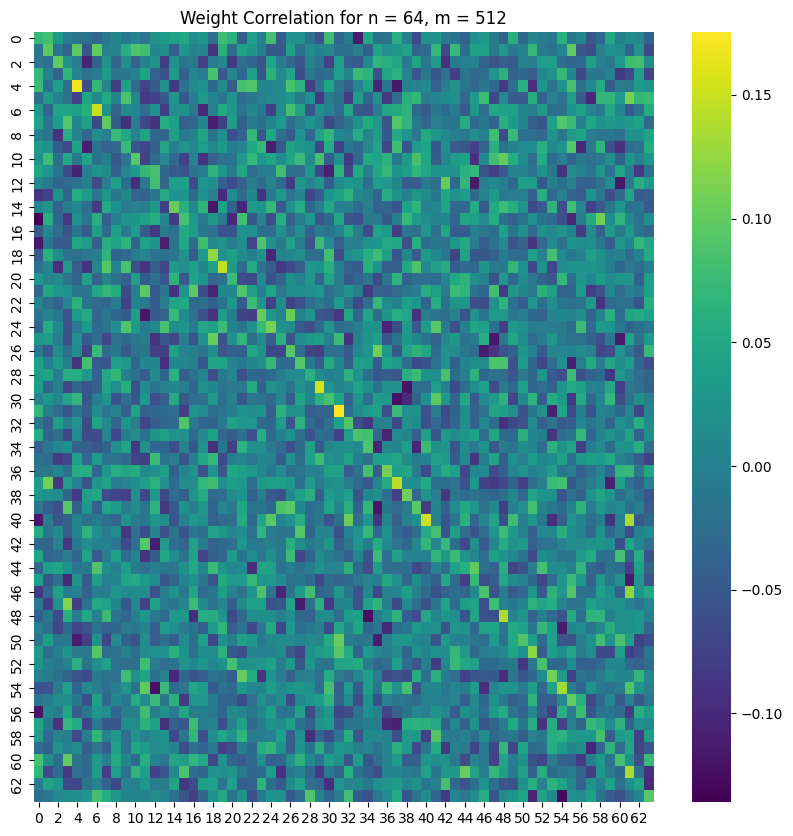

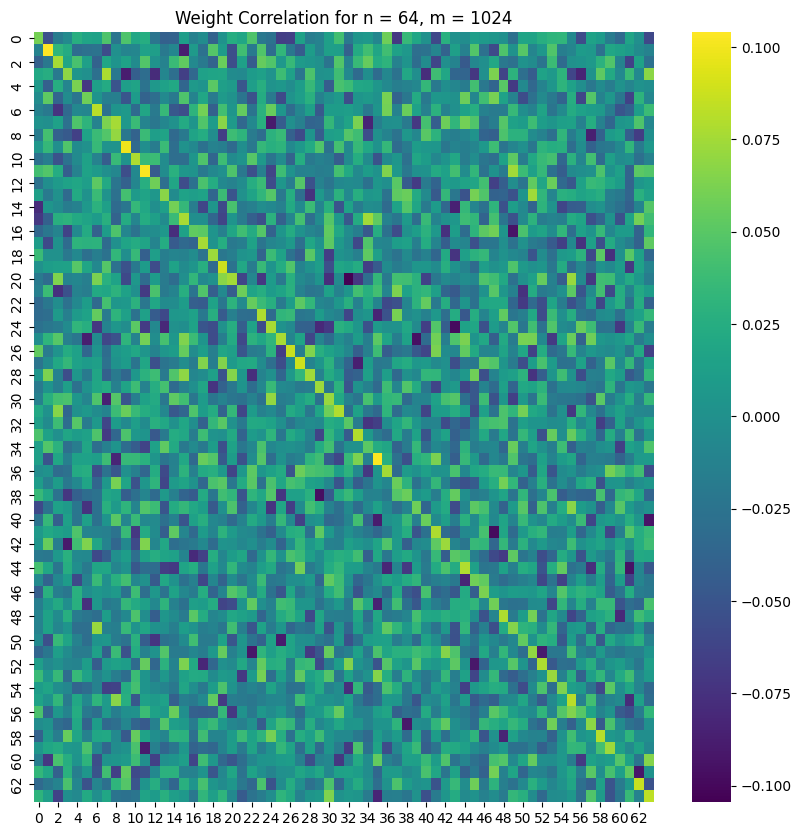

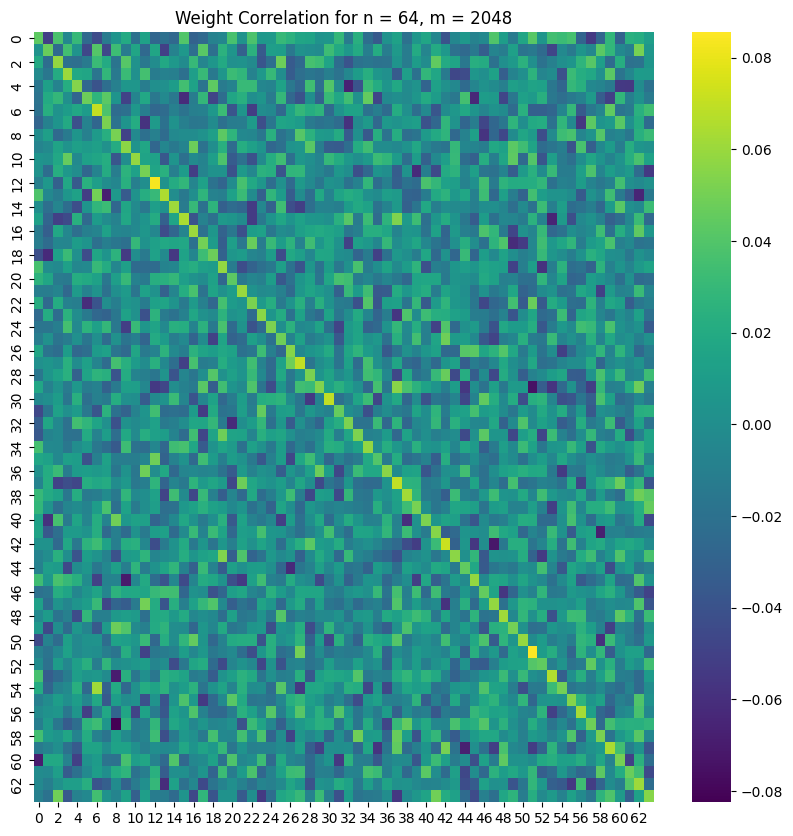

In [ ]:
correlation_plots = []

for size, start_matrix, end_matrix in zip(hidden_64, start_weights_64, weights_64):
  correlation = start_matrix @ end_matrix.T
  plt.figure(figsize=(10,10))
  sns.heatmap(correlation, cmap="viridis")
  plt.title(f"Weight Correlation for n = 64, m = {size}")
  correlation_plots.append(plt.gcf())

## Quantifying the amount of polysemanticity

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

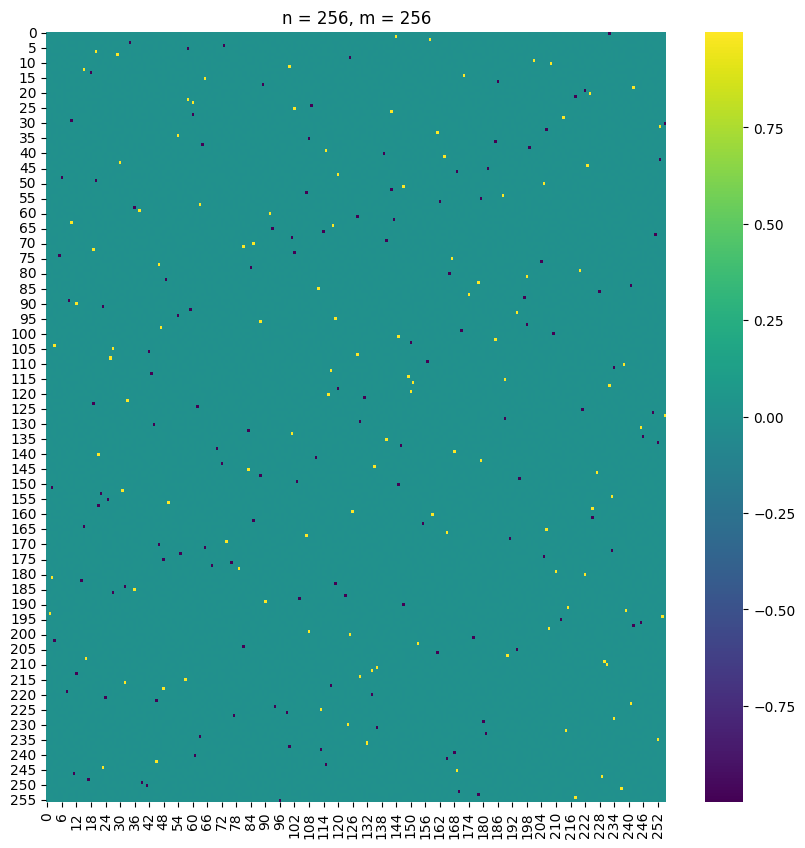

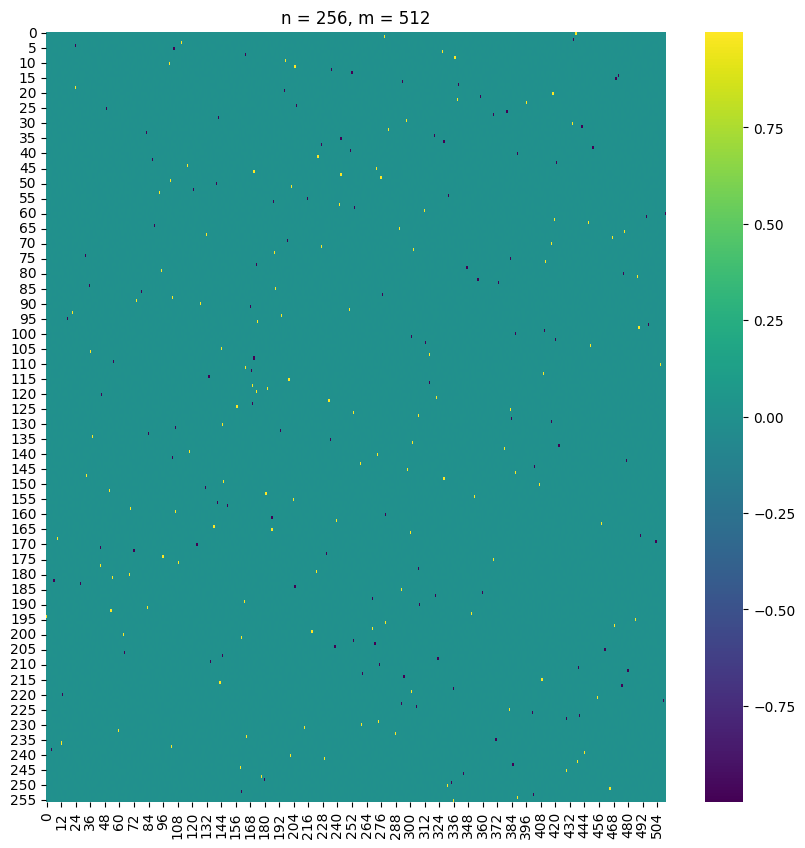

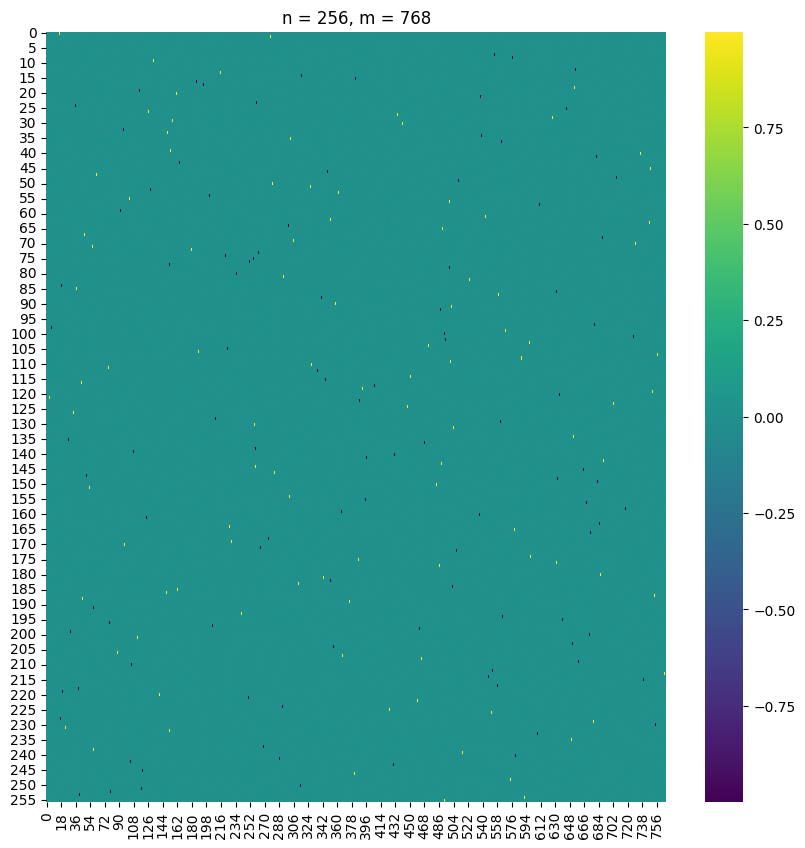

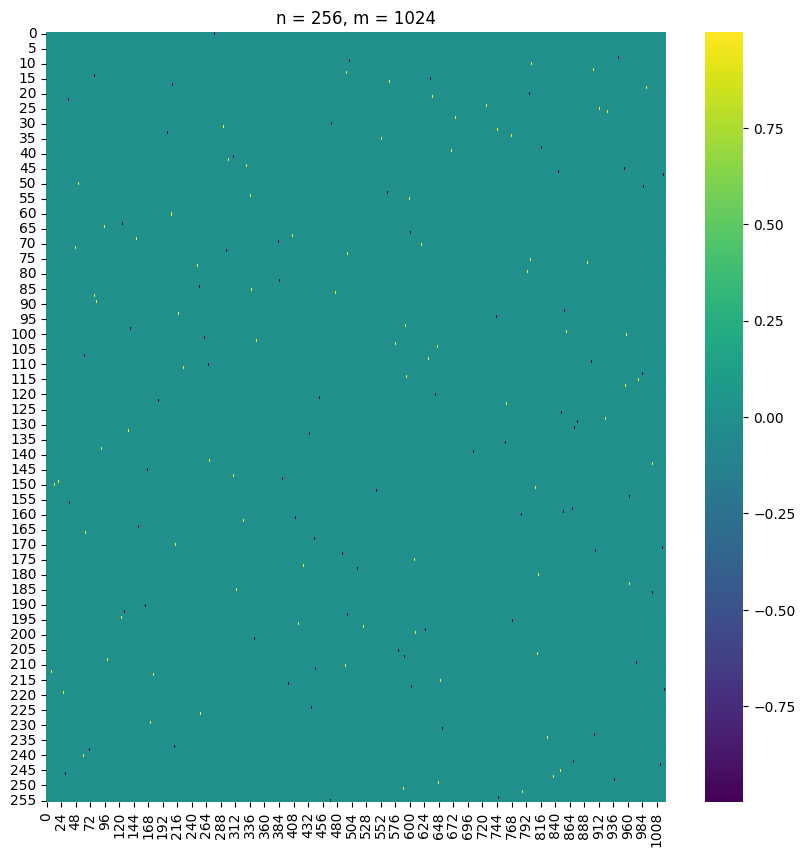

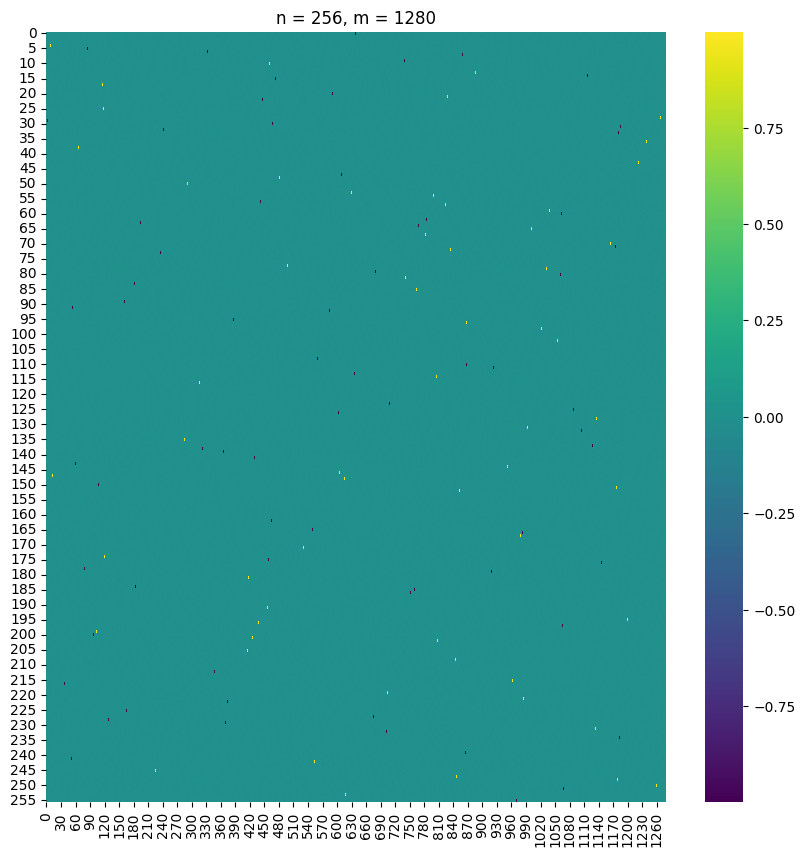

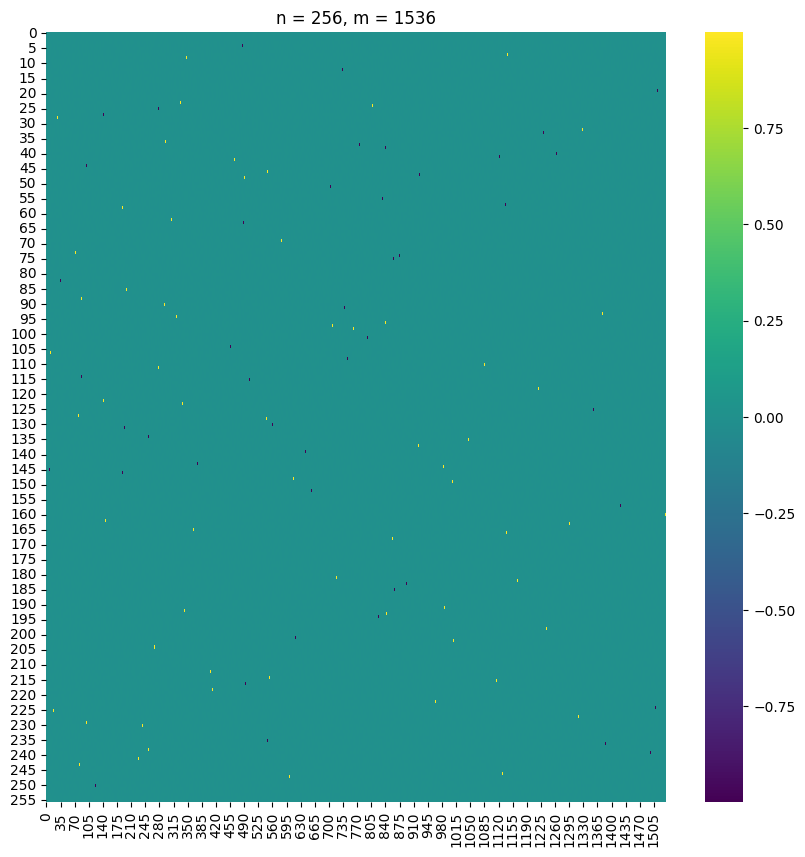

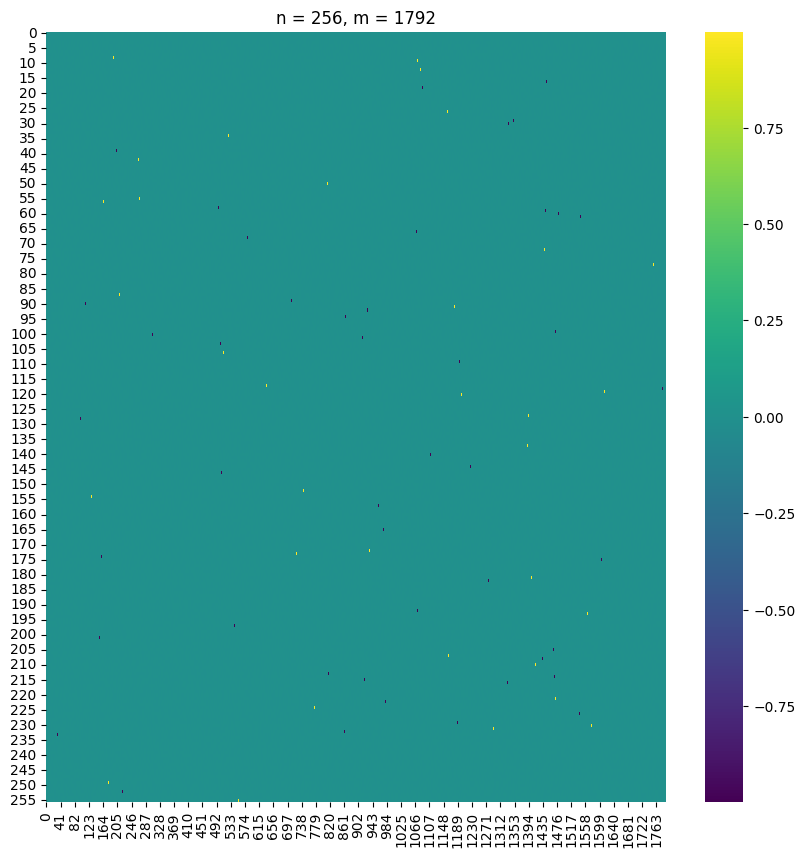

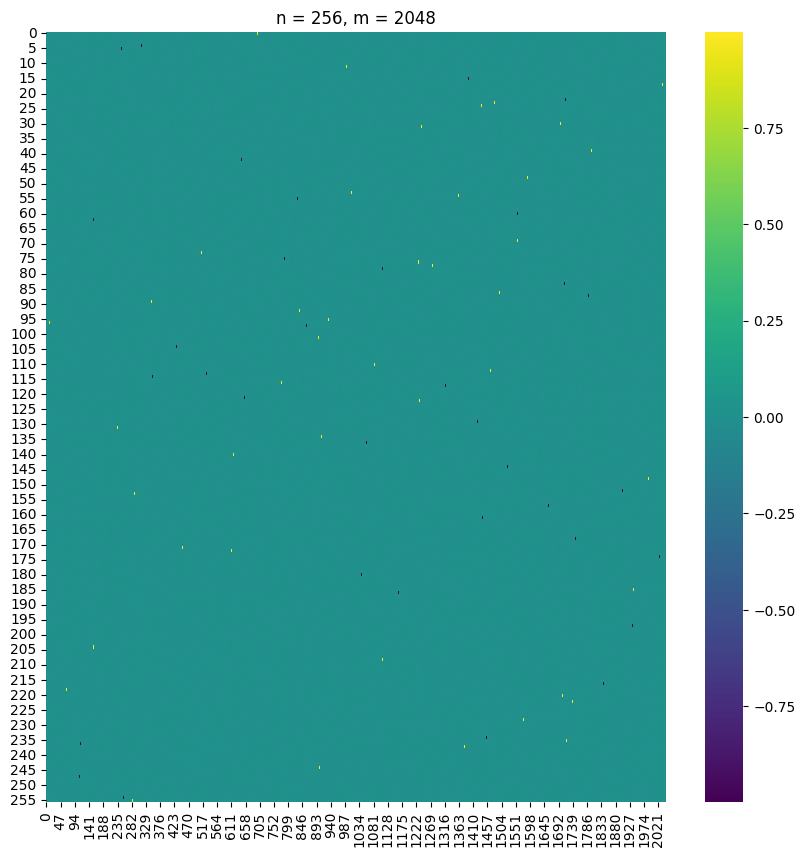

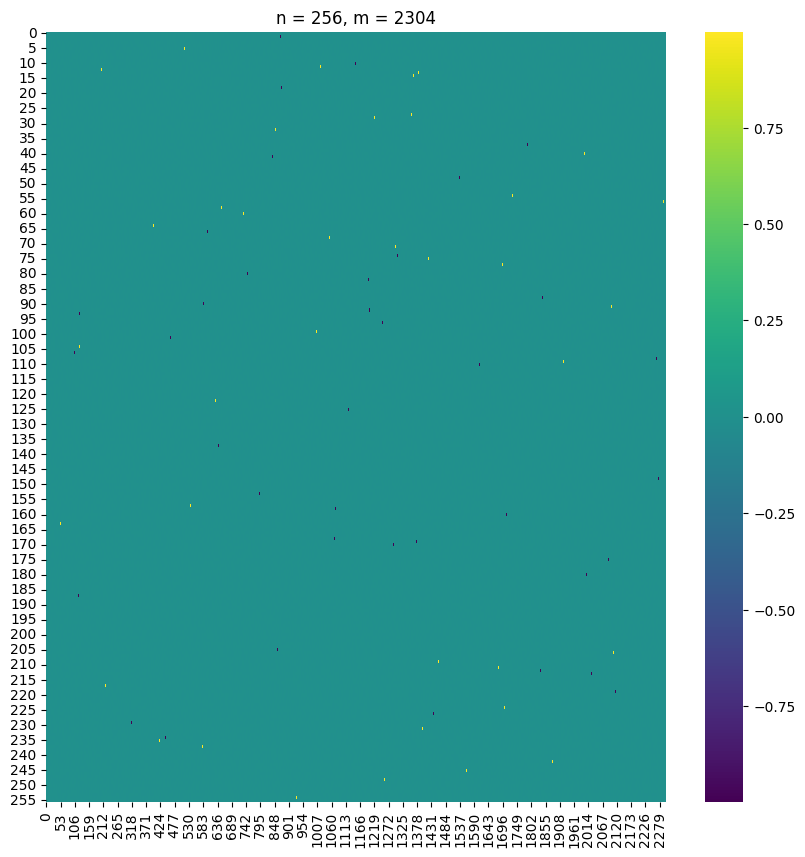

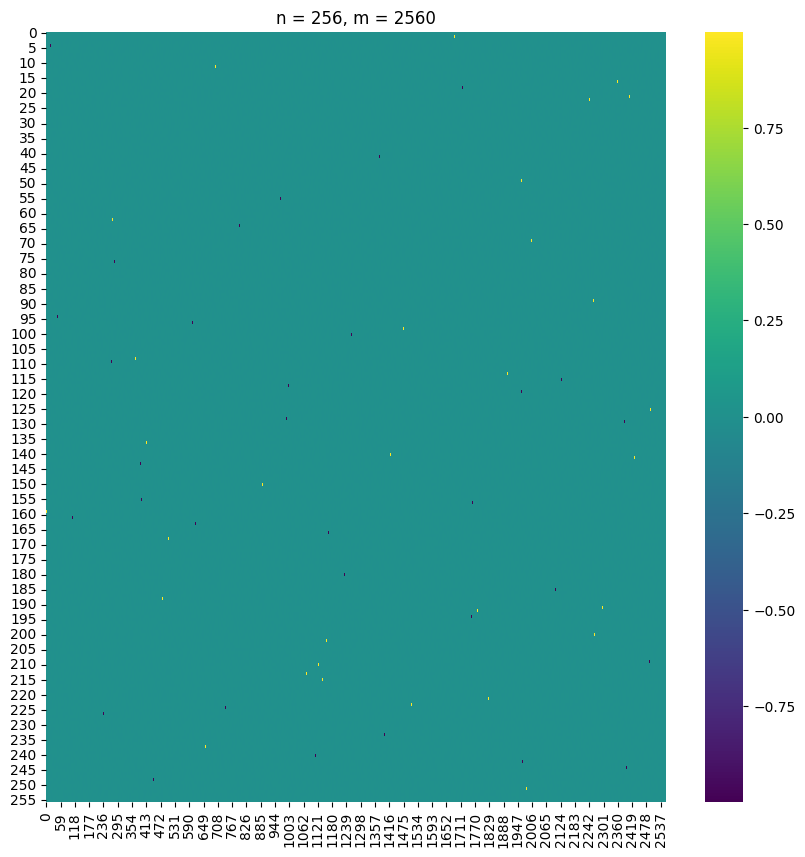

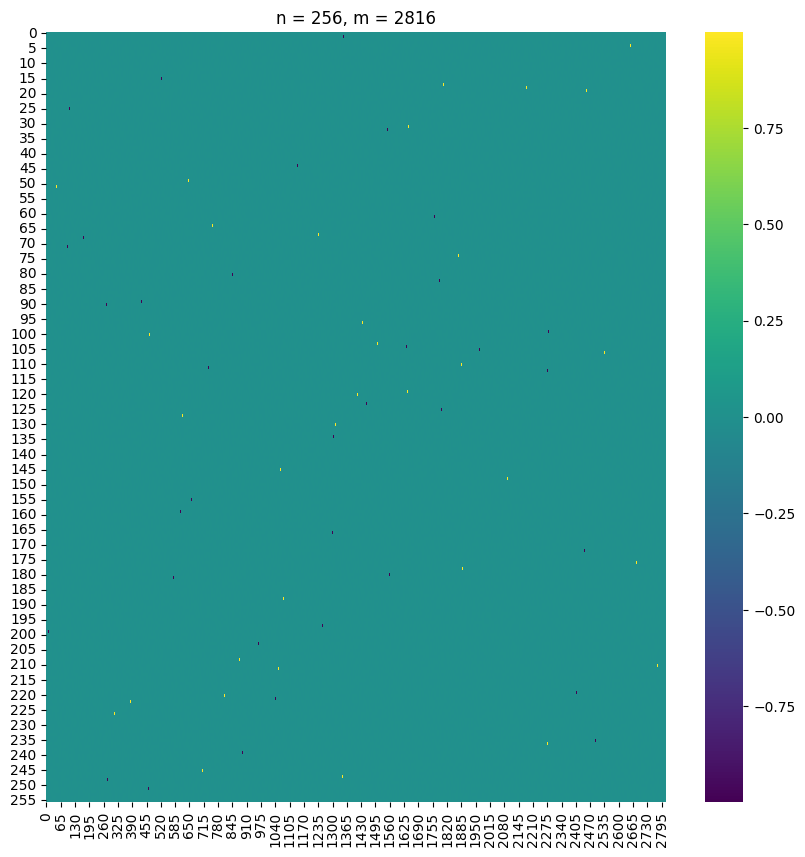

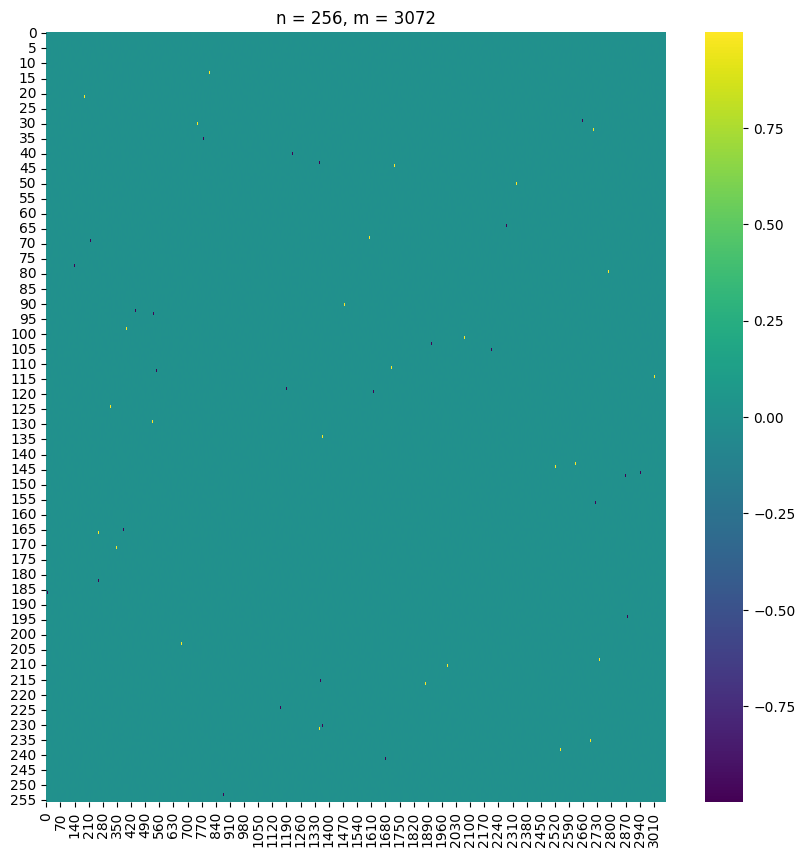

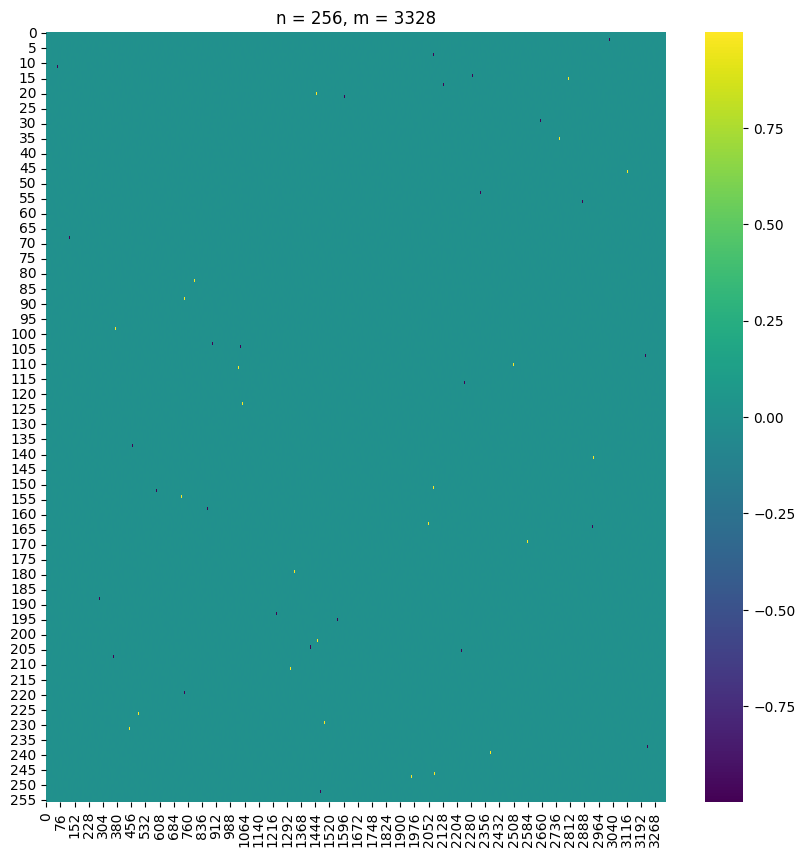

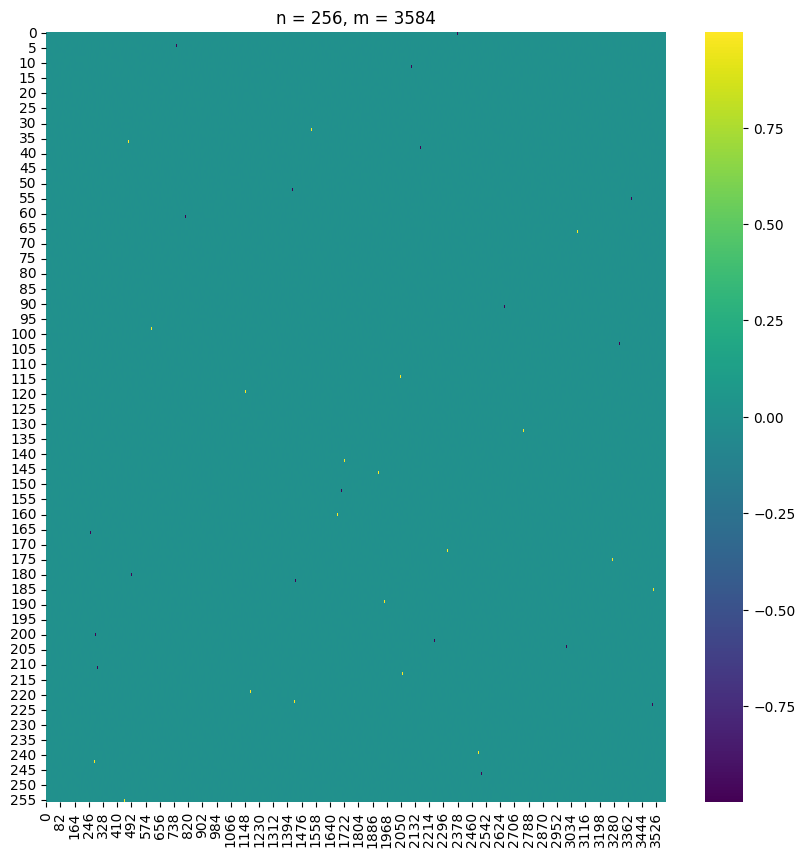

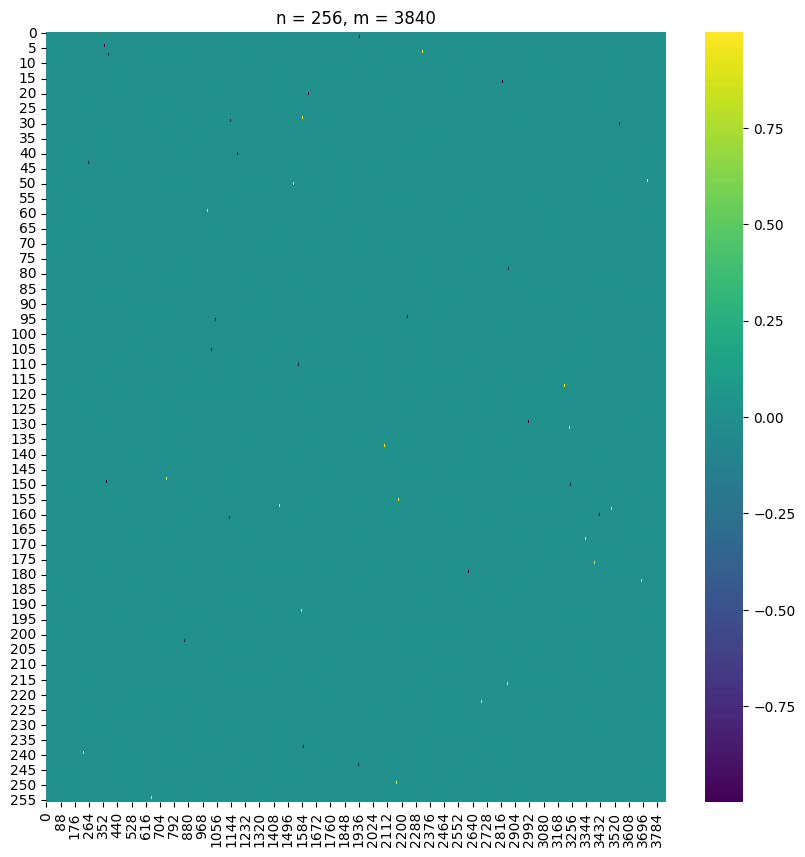

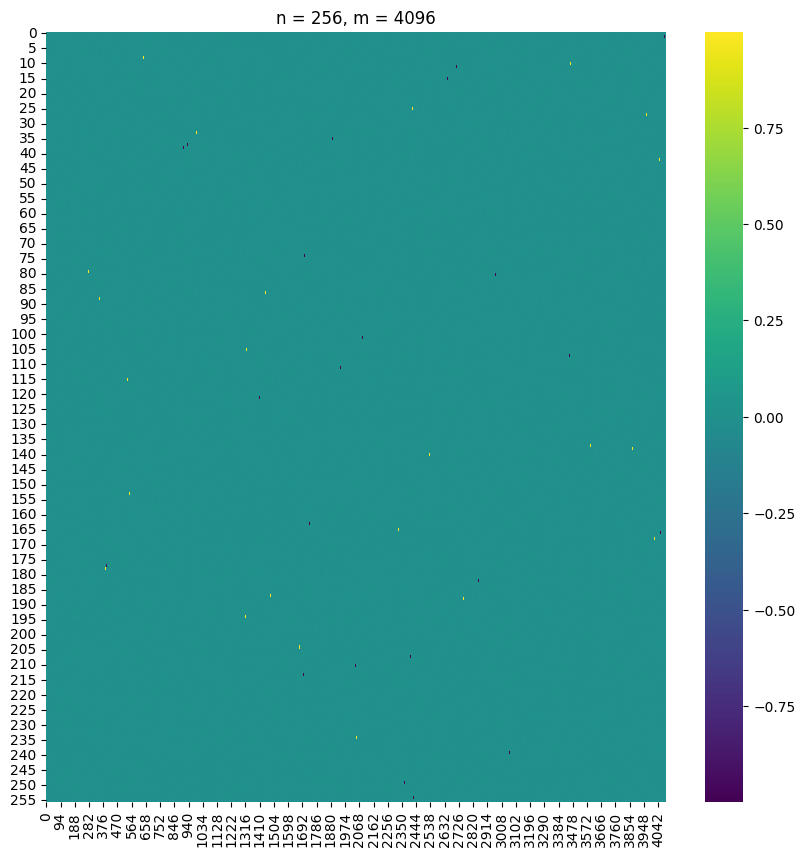

In [ ]:
hidden_256 = [256, 512, 768, 1024, 1280, 1536, 1792, 2048, 2304, 2560, 2816, 3072, 3328, 3584, 3840, 4096]

start_weights_256 = []
weights_256 = []
activations_256 = []
polysemantics_256 = []
plots_256 = []

for size in hidden_256:
  config = Config(
      n_features=256,
      n_hidden=size,
      n_instances=1,
      inputs="basis",
      tied=True,
      distri="normal",
      bias=False,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, l1_factor=0.00005)

  start_matrix = model.W_initial.detach().cpu().numpy()
  start_matrix = start_matrix[0]
  start_weights_256.append(start_matrix)

  weight_matrix = model.W.detach().cpu().numpy()
  weight_matrix = weight_matrix[0]
  weights_256.append(weight_matrix)
  absolute_matrix = np.abs(weight_matrix)

  activation_mask = (absolute_matrix >= 0.8) & (absolute_matrix <= 1.2)
  count_total_activate = np.sum(activation_mask)
  activations_256.append(count_total_activate)

  # note we count polysemanticity by 0.8-1.2 here
  # this is because we expect to see 1 and -1
  count_neuron_activate = activation_mask.sum(axis=0)
  count_polysemantic = sum(1 for num in count_neuron_activate if num > 1.25)
  polysemantics_256.append(count_polysemantic)

  plt.figure(figsize=(10,10))
  sns.heatmap(weight_matrix, cmap="viridis")
  plt.title(f"n = 256, m = {size}")
  plots_256.append(plt.gcf())

In [ ]:
print(activations_256)
print(polysemantics_256)

[256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256]
[68, 29, 9, 8, 4, 13, 8, 7, 6, 6, 7, 7, 3, 4, 1, 5]


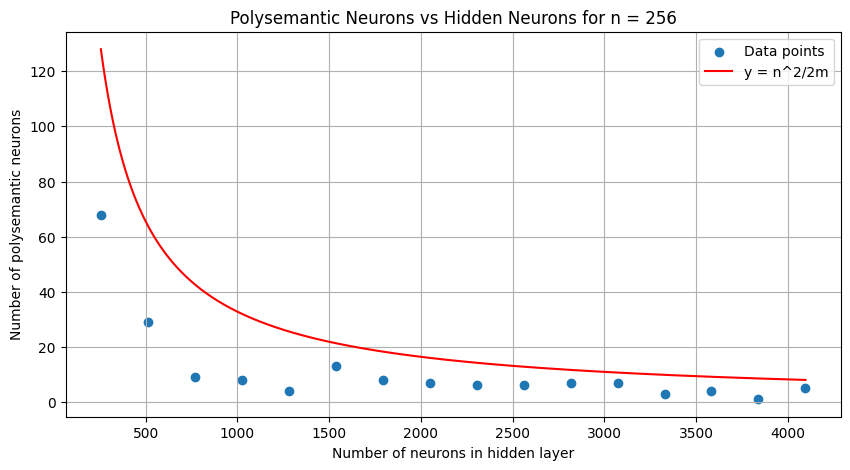

In [ ]:
x = np.array(hidden_256)
y = np.array(polysemantics_256)

plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Data points')

x_line = np.linspace(min(x), max(x), 1000)  # Equally spaced points between min and max of x
y_line = 65536 / (2 * x_line)  # 256 squared divided by 2
plt.plot(x_line, y_line, color='r', label='y = n^2/2m')

plt.xlabel('Number of neurons in hidden layer')
plt.ylabel('Number of polysemantic neurons')
plt.title('Polysemantic Neurons vs Hidden Neurons for n = 256')
plt.grid(True)
plt.legend()
plt.show()

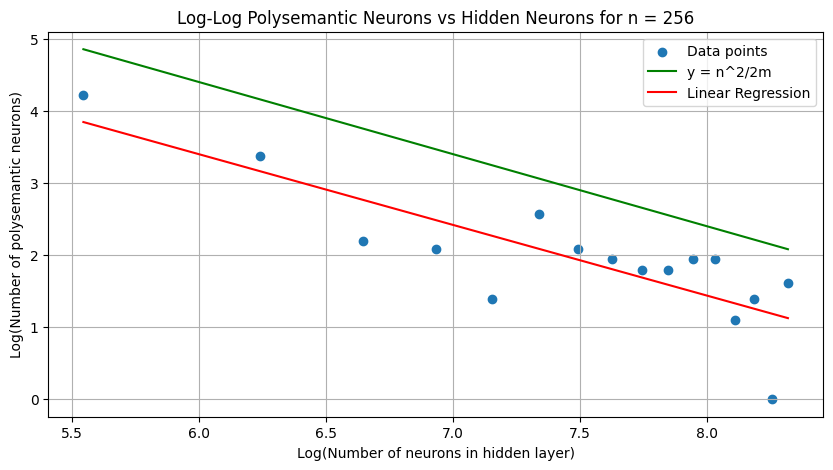

Coefficients:  [-0.9804594   9.27946274]


In [ ]:
log_x = np.log(x)
log_y = np.log(y)
log_x_line = np.log(x_line)
log_y_line = np.log(y_line)

coefficients = np.polyfit(log_x, log_y, 1)
regression_line = np.polyval(coefficients, log_x)

plt.figure(figsize=(10, 5))
plt.scatter(log_x, log_y, label='Data points')
plt.plot(log_x_line, log_y_line, color='green', label='y = n^2/2m')
plt.plot(log_x, regression_line, color='red', label='Linear Regression')
plt.xlabel('Log(Number of neurons in hidden layer)')
plt.ylabel('Log(Number of polysemantic neurons)')
plt.title('Log-Log Polysemantic Neurons vs Hidden Neurons for n = 256')
plt.grid(True)
plt.legend()
plt.show()

print("Coefficients: ", coefficients)

## Identity matrix for correlated features

In [ ]:
hidden_50 = [50]

encoder_50 = []
decoder_50 = []
bias_50 = []

for size in hidden_50:
  config = Config(
      n_features=50,
      n_hidden=size,
      n_instances=1,
      inputs="correlated",
      tied=False,
      distri="normal",
      bias=True,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, n_batch=100, l1_factor=0.0005)

  encoder_matrix = model.encoder.detach().cpu().numpy()
  encoder_matrix = encoder_matrix[0]
  encoder_50.append(encoder_matrix)

  decoder_matrix = model.decoder.detach().cpu().numpy()
  decoder_matrix = decoder_matrix[0]
  decoder_50.append(decoder_matrix)

  bias_vector = model.bias.detach().cpu().numpy()
  bias_50.append(bias_vector)

  0%|          | 0/10000 [00:00<?, ?it/s]

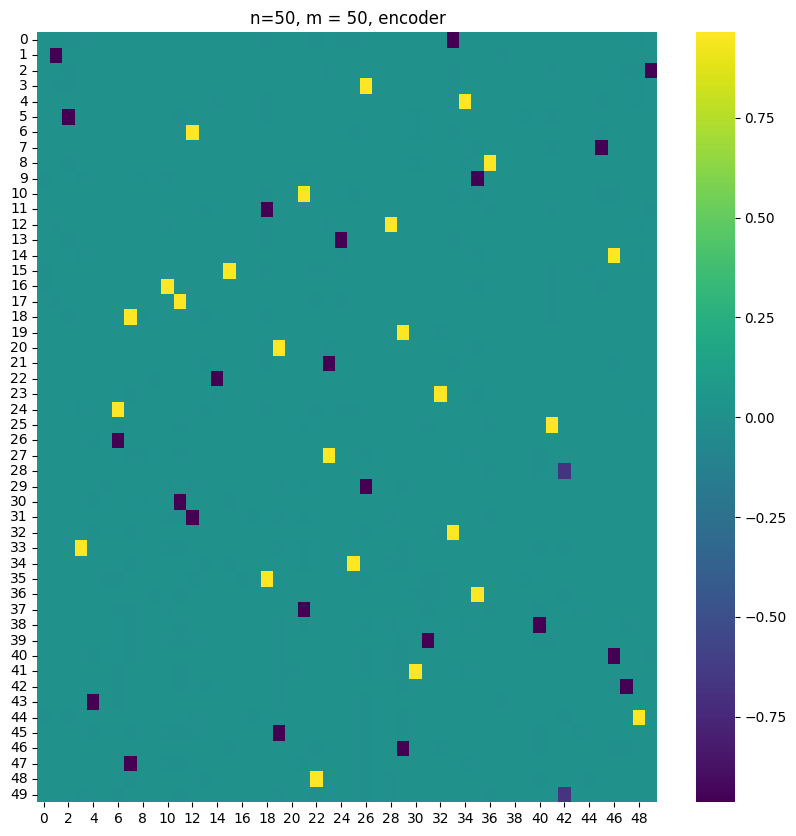

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, encoder")
plt.show()

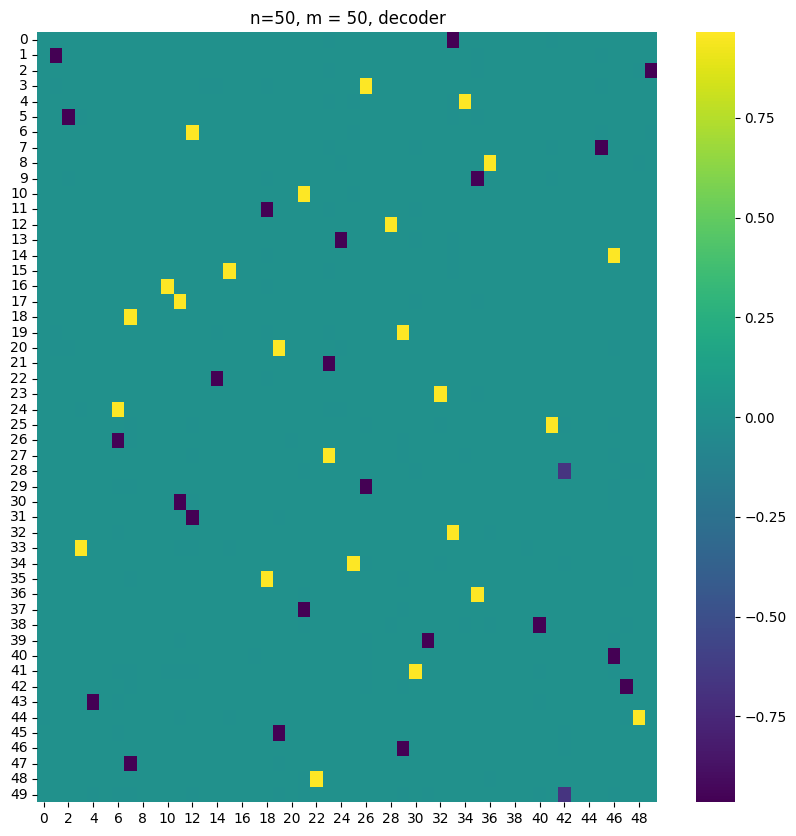

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(decoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, decoder")
plt.show()

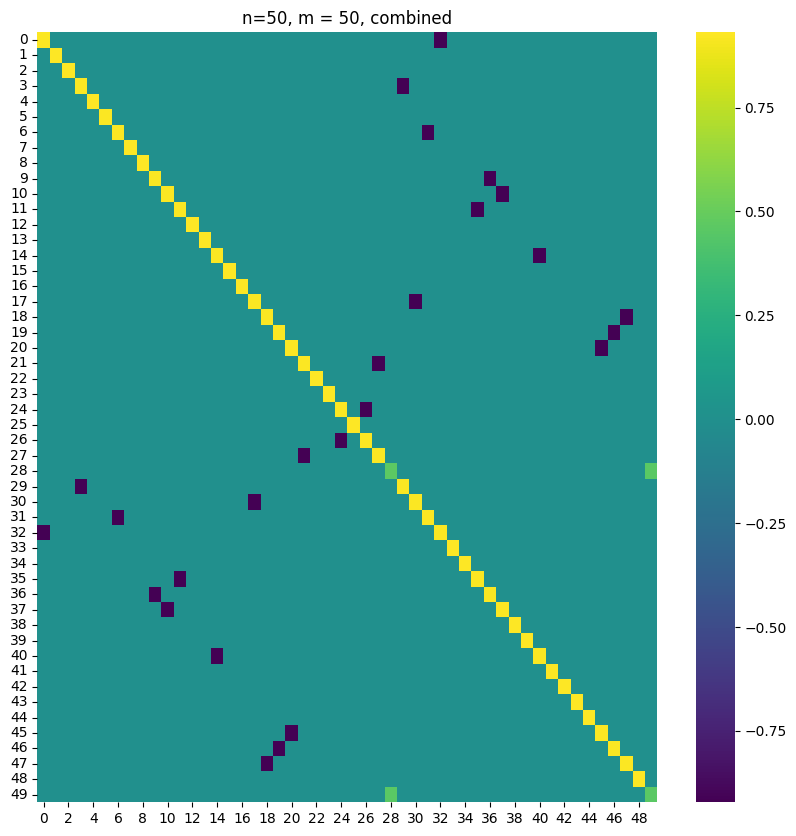

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0] @ decoder_50[0].T, cmap="viridis")
plt.title("n=50, m = 50, combined")
plt.show()

## Inducing lossless polysemanticity with correlated features

In [ ]:
hidden_50 = [50]

encoder_50 = []
decoder_50 = []
bias_50 = []

for size in hidden_50:
  config = Config(
      n_features=50,
      n_hidden=size,
      n_instances=1,
      inputs="correlated",
      tied=False,
      distri="xavier",
      bias=True,
      nonlinear=True)

  model = Model(
      config=config,
      device=DEVICE)

  optimize(model, n_batch=100, l1_factor=0.0005)

  encoder_matrix = model.encoder.detach().cpu().numpy()
  encoder_matrix = encoder_matrix[0]
  encoder_50.append(encoder_matrix)

  decoder_matrix = model.decoder.detach().cpu().numpy()
  decoder_matrix = decoder_matrix[0]
  decoder_50.append(decoder_matrix)

  bias_vector = model.bias.detach().cpu().numpy()
  bias_50.append(bias_vector)

  0%|          | 0/10000 [00:00<?, ?it/s]

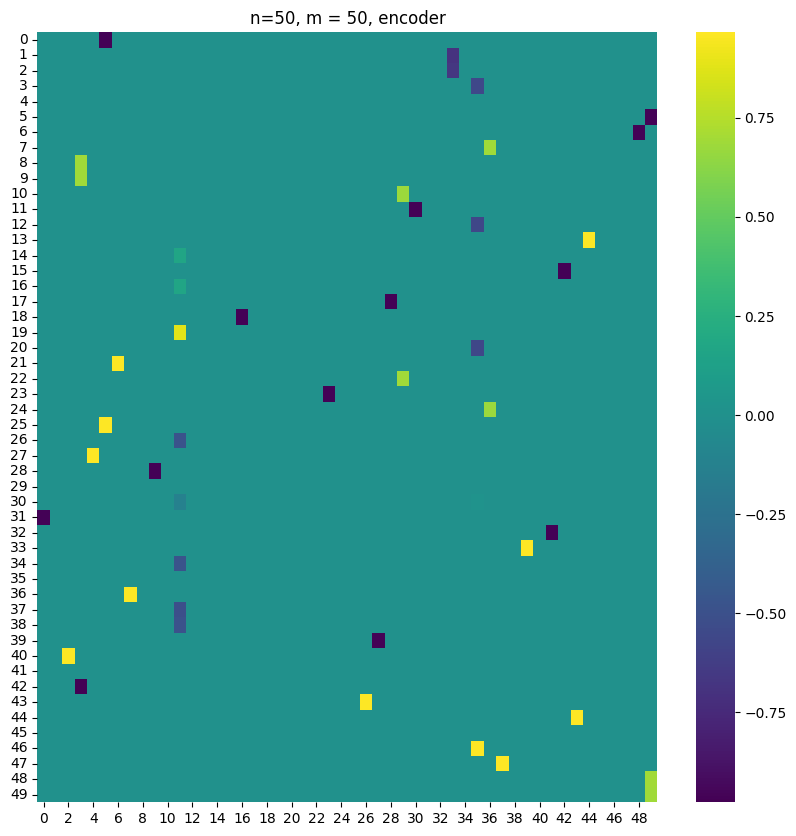

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, encoder")
plt.show()

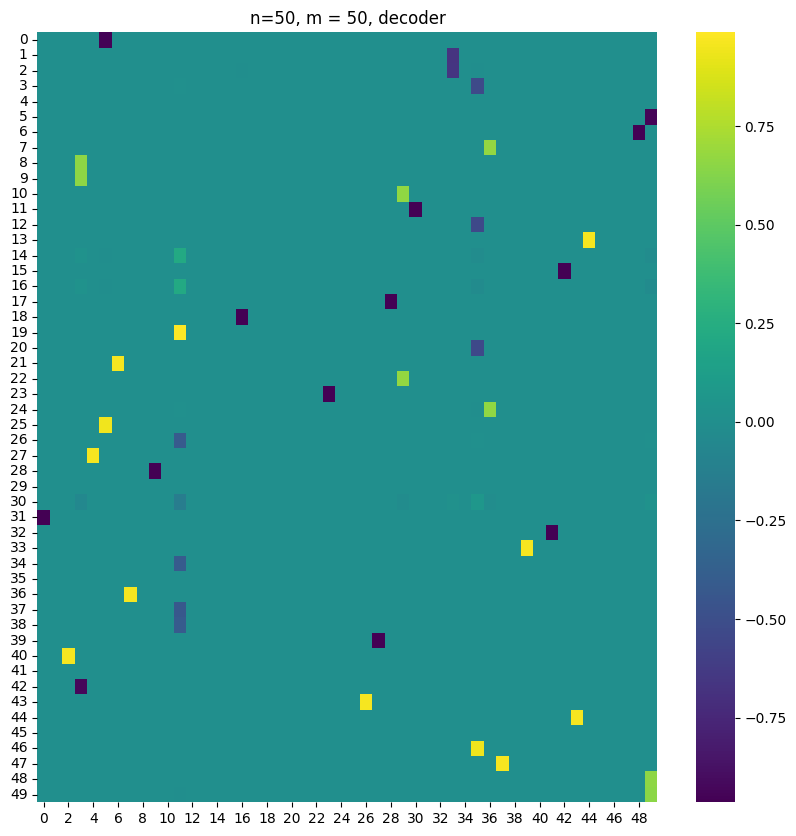

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(decoder_50[0], cmap="viridis")
plt.title("n=50, m = 50, decoder")
plt.show()

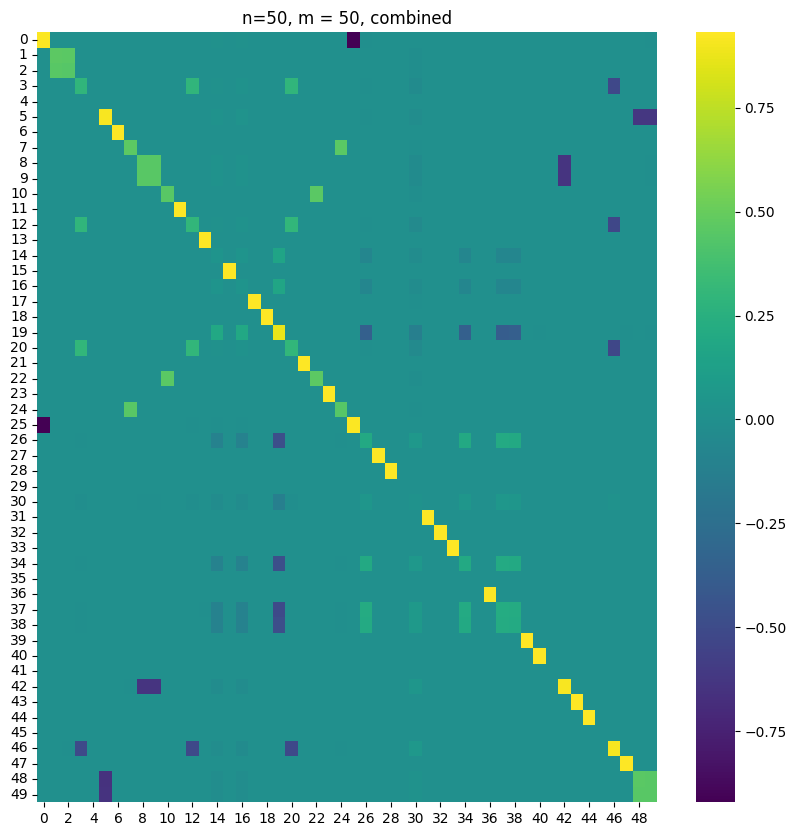

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(encoder_50[0] @ decoder_50[0].T, cmap="viridis")
plt.title("n=50, m = 50, combined")
plt.show()